# How To: Modifying Models At Runtime

Now it gets really interesting and rather complex. The goal is to replace certain equations of the model with custom lambda functions at runtime. 

First we need to obtain the scenarios and their corresponding simulation models and replace the given equations with the new lambda. 
An extended strategy is just another dictionary. In general, it looks like this:
```
scenarios = bptk.get_scenarios(scenario_managers=["smSimpleProjectManagement"])

extended_strategy= {
    "scenario80" : {
        "10" : { 
            "initialOpenTasks" : lambda t :0 if t <= 1 else 42 + scenarios["scenario80"].model.memoize("initialOpenTasks",t-1) ,
        }
    }    
}
```
You see that this concept is rather complex and requires understanding of Python. First we have to load all available scenarios. The dictionary contains *pointers* to the specific scenario objects that we loaded from the scenario files. They are stored in the ``ScenarioManager`` object instance of the ``bptk`` object. The lambda functions now have to use these scenarios pointers to receive the pointers to the ``model`` object (and therefore the equations) of the simulation model. 
We will overwrite the specific equations with the given lambda function(s) in the previously-described strategy dictionary of the scenario. It is possible to store lambda functions just like this as strings in JSON **but** the complexity is even higher when it comes to adding it to the model during run-time. As the bptk object uses the same set of scenarios, it will use the same object pointers when we finally issue ``bptk.plot_scenarios(... ,strategy=True)``

We begin with defining the new, extended strategy. It plays a around with the initial open Tasks. It will return 0 if at starttime of the model. Otherwise, it returns the value of t-dt multiplied by 1,000. See also how we get the dt and start time of the model by accessing the scenarios.


In [1]:
from BPTK_Py.bptk import bptk
bptk=bptk()
scenarios = bptk.get_scenarios(scenario_managers=["smSimpleProjectManagement"])

dt = scenarios["scenario80"].model.dt


extended_strategy= {
    "scenario80" : {
        "10" : { 
            "initialOpenTasks" : lambda t :0 if t <= 1 else 500 + scenarios["scenario80"].model.memoize("initialOpenTasks",t-1) ,
            "deadline" : lambda t : 80
        }
    }    
}

bptk.modify_strategy(scenarios=scenarios,extended_strategy=extended_strategy)



And now we run the method ``bptk.modify_strategy(scenarios,extended_strategy)``. It receives the pointers to the scenarios object and the modifications to the existing strategy. The method will just take the dictionary and fill up the strategy field of the scenario(s) with the lambda function objects.

Please keep in mind that ``bptk`` stores the old lambda function. It runs the simulation until ``t-1``, inserts the new function and continues until the next change. If you want to re-run the scenario with another modified strategy, just flush the ``ScenarioManager``'s ``scenario`` object:
```
bptk.reset_simulation_model(scenario_name="scenario80",scenario_manager="smSimpleProjectManagement")
```
This will cause the scenario manager to reload the scenario's simulation model from the source file.
Finally, you may use the plotting methods with the ``strategy=True`` parameter for simulating and plotting the modified scenarios. 

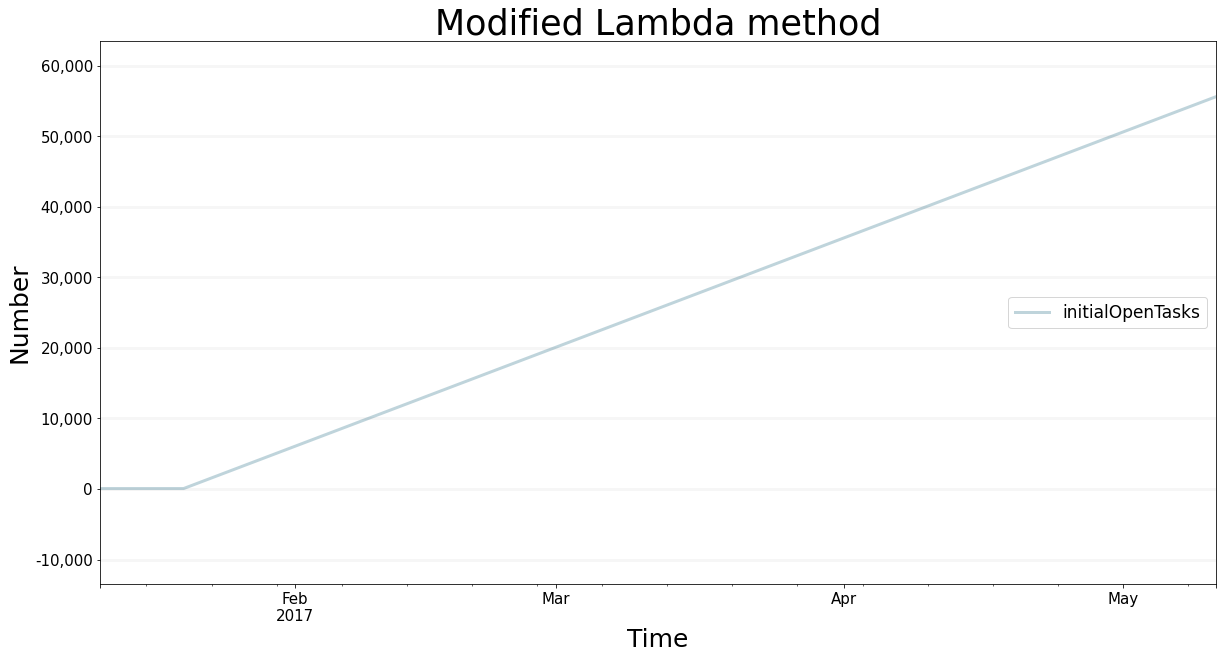

In [2]:
## Plot the graph with the extended stratefy
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80"],
    kind="line",
    equations=["initialOpenTasks"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Modified Lambda method",
    x_label="Time",
    y_label="Number"
)